# 12.3a: Sigma Sweep Analysis

**Goal:** Analyze synthetic snowball data from 12.2a and compare to Qwen 3 4B Instruct 2507's actual black hole structure.

## Qwen Target Structure

- **Black hole count:** 13
- **Dead token population:** ~2,100 tokens
- **Max L∞:** ≈ 1× ULP (6×10⁻⁵)
- **Touching criterion:** Essentially all pairs touch (L∞ ≤ 2ε)

## Analysis Plan

1. Load synthetic snowball data from CSV
2. Identify candidates with C = 13 black holes
3. For each candidate, compare:
   - Black hole population vs. 2,100 target
   - Spatial extent (max L∞) vs. 1× ULP target
   - Mean/median L∞ distributions
4. Compute combined similarity score
5. Visualize trends across σ range

## Parameters

In [1]:
# Qwen 3 4B Instruct 2507 targets
TARGET_BLACK_HOLES = 13
TARGET_POPULATION = 2100
TARGET_MAX_L_INF = 6e-5  # ~1× ULP

# Data
DATA_PATH = "../data/analysis/sigma_sweep_qwen_scale.csv"

# Epsilon (from 12.2a)
EPSILON = 6e-5

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [3]:
print(f"Loading sweep data from {DATA_PATH}...\n")

df = pd.read_csv(DATA_PATH)

print(f"✓ Data loaded")
print(f"  Samples: {len(df):,}")
print(f"  Columns: {list(df.columns)}")
print(f"\nSigma range:")
print(f"  Min: {df['sigma'].min():.2e}")
print(f"  Max: {df['sigma'].max():.2e}")

Loading sweep data from ../data/analysis/sigma_sweep_qwen_scale.csv...

✓ Data loaded
  Samples: 1,000
  Columns: ['sigma', 'unique_vectors', 'n_black_holes', 'black_hole_population', 'n_singletons', 'largest_bh', 'max_l_inf', 'mean_l_inf', 'median_l_inf', 'n_tokens', 'hidden_dim', 'epsilon', 'sigma_over_epsilon', 'max_l_inf_over_epsilon']

Sigma range:
  Min: 1.50e-09
  Max: 5.00e-09


## Black Hole Count Distribution

In [4]:
print(f"\n{'='*60}")
print(f"BLACK HOLE COUNT DISTRIBUTION")
print(f"{'='*60}")

bh_counts = df['n_black_holes'].value_counts().sort_index()
print(f"\nCounts observed:")
for count, n_samples in bh_counts.items():
    marker = " ← TARGET" if count == TARGET_BLACK_HOLES else ""
    print(f"  C = {count:2d}: {n_samples:4d} samples{marker}")

# Samples with black holes
samples_with_bh = (df['n_black_holes'] > 0).sum()
print(f"\nSamples with any black holes: {samples_with_bh:,} / {len(df):,} ({samples_with_bh/len(df)*100:.1f}%)")


BLACK HOLE COUNT DISTRIBUTION

Counts observed:
  C = 12:    4 samples
  C = 13:   10 samples ← TARGET
  C = 14:   20 samples
  C = 15:   17 samples
  C = 16:    8 samples
  C = 17:   16 samples
  C = 18:   14 samples
  C = 19:    7 samples
  C = 20:    7 samples
  C = 21:    9 samples
  C = 22:   11 samples
  C = 23:    9 samples
  C = 24:    9 samples
  C = 25:    4 samples
  C = 26:    8 samples
  C = 27:   15 samples
  C = 28:    9 samples
  C = 29:    4 samples
  C = 30:    7 samples
  C = 31:   12 samples
  C = 32:    3 samples
  C = 33:   12 samples
  C = 34:    7 samples
  C = 35:    4 samples
  C = 36:    6 samples
  C = 37:    6 samples
  C = 38:    9 samples
  C = 39:    8 samples
  C = 40:    8 samples
  C = 41:    3 samples
  C = 42:    9 samples
  C = 43:    5 samples
  C = 44:    5 samples
  C = 45:    5 samples
  C = 46:    7 samples
  C = 47:    2 samples
  C = 48:   12 samples
  C = 49:    4 samples
  C = 50:    7 samples
  C = 51:    4 samples
  C = 52:    6 samples

## Identify C=13 Candidates

In [5]:
candidates = df[df['n_black_holes'] == TARGET_BLACK_HOLES].copy()

print(f"\n{'='*60}")
print(f"C = {TARGET_BLACK_HOLES} CANDIDATES")
print(f"{'='*60}")
print(f"Found {len(candidates)} candidate(s) with exactly {TARGET_BLACK_HOLES} black holes\n")

if len(candidates) > 0:
    print(candidates[[
        'sigma', 'n_black_holes', 'black_hole_population', 'n_singletons',
        'largest_bh', 'max_l_inf', 'mean_l_inf', 'median_l_inf',
        'sigma_over_epsilon', 'max_l_inf_over_epsilon'
    ]].to_string(index=False))
else:
    print("No candidates found with exactly 13 black holes.")


C = 13 CANDIDATES
Found 10 candidate(s) with exactly 13 black holes

       sigma  n_black_holes  black_hole_population  n_singletons  largest_bh  max_l_inf   mean_l_inf  median_l_inf  sigma_over_epsilon  max_l_inf_over_epsilon
1.510511e-09             13                   2097             3        1106   0.000015 2.697492e-06  4.768372e-07            0.000025                0.254313
1.514014e-09             13                   2099             1        1082   0.000015 2.697492e-06  4.768372e-07            0.000025                0.254313
1.521021e-09             13                   2095             5        1111   0.000015 4.604459e-06  4.768372e-07            0.000025                0.254313
1.531532e-09             13                   2094             6        1090   0.000015 4.601402e-06  4.768372e-07            0.000026                0.254313
1.535035e-09             13                   2098             2        1078   0.000002 6.434245e-07  4.768372e-07            0.000026 

## Compute Similarity Metrics

In [6]:
print(f"\n{'='*60}")
print(f"SIMILARITY TO QWEN")
print(f"{'='*60}")

if len(candidates) > 0:
    # Compute similarity scores for each candidate
    candidates['pop_error'] = np.abs(candidates['black_hole_population'] - TARGET_POPULATION) / TARGET_POPULATION
    candidates['max_l_inf_error'] = np.abs(candidates['max_l_inf'] - TARGET_MAX_L_INF) / TARGET_MAX_L_INF
    
    # Combined score (lower is better)
    candidates['combined_error'] = candidates['pop_error'] + candidates['max_l_inf_error']
    
    # Sort by combined error
    candidates_sorted = candidates.sort_values('combined_error')
    
    print(f"\nQwen targets:")
    print(f"  Black holes: {TARGET_BLACK_HOLES}")
    print(f"  Population: {TARGET_POPULATION:,}")
    print(f"  Max L∞: {TARGET_MAX_L_INF:.2e} ({TARGET_MAX_L_INF/EPSILON:.2f}× ε)")
    print(f"\nBest match:")
    
    best = candidates_sorted.iloc[0]
    print(f"  σ = {best['sigma']:.2e} ({best['sigma_over_epsilon']:.4f}× ε)")
    print(f"  Black holes: {best['n_black_holes']:.0f}")
    print(f"  Population: {best['black_hole_population']:.0f} (error: {best['pop_error']*100:.1f}%)")
    print(f"  Singletons: {best['n_singletons']:.0f}")
    print(f"  Largest BH: {best['largest_bh']:.0f} tokens")
    print(f"  Max L∞: {best['max_l_inf']:.2e} ({best['max_l_inf_over_epsilon']:.2f}× ε, error: {best['max_l_inf_error']*100:.1f}%)")
    print(f"  Mean L∞: {best['mean_l_inf']:.2e} ({best['mean_l_inf']/EPSILON:.2f}× ε)")
    print(f"  Median L∞: {best['median_l_inf']:.2e} ({best['median_l_inf']/EPSILON:.2f}× ε)")
    print(f"  Combined error: {best['combined_error']:.3f}")
    
    if len(candidates_sorted) > 1:
        print(f"\nAll {len(candidates_sorted)} candidates (sorted by combined error):")
        print(candidates_sorted[[
            'sigma', 'black_hole_population', 'max_l_inf',
            'pop_error', 'max_l_inf_error', 'combined_error'
        ]].to_string(index=False))
else:
    print("\nNo candidates to analyze.")


SIMILARITY TO QWEN

Qwen targets:
  Black holes: 13
  Population: 2,100
  Max L∞: 6.00e-05 (1.00× ε)

Best match:
  σ = 1.51e-09 (0.0000× ε)
  Black holes: 13
  Population: 2099 (error: 0.0%)
  Singletons: 1
  Largest BH: 1082 tokens
  Max L∞: 1.53e-05 (0.25× ε, error: 74.6%)
  Mean L∞: 2.70e-06 (0.04× ε)
  Median L∞: 4.77e-07 (0.01× ε)
  Combined error: 0.746

All 10 candidates (sorted by combined error):
       sigma  black_hole_population  max_l_inf  pop_error  max_l_inf_error  combined_error
1.514014e-09                   2099   0.000015   0.000476         0.745687        0.746163
1.510511e-09                   2097   0.000015   0.001429         0.745687        0.747115
1.556056e-09                   2096   0.000015   0.001905         0.745687        0.747592
1.521021e-09                   2095   0.000015   0.002381         0.745687        0.748068
1.538539e-09                   2095   0.000015   0.002381         0.745687        0.748068
1.531532e-09                   2094   0.000

## Visualize Trends Across σ

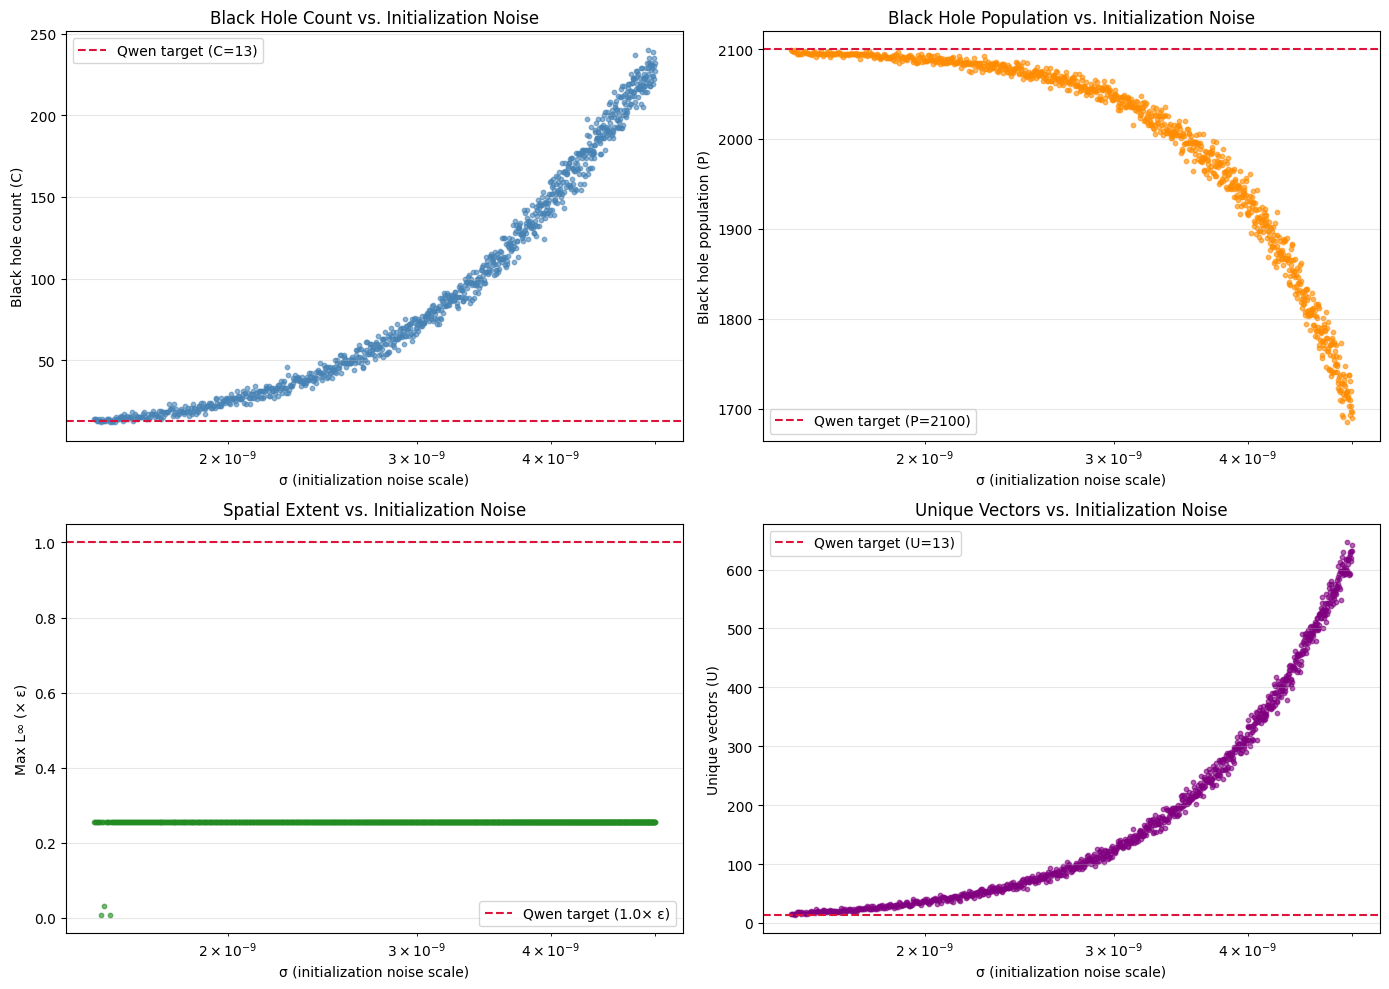

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Panel 1: Black hole count vs sigma
ax = axes[0, 0]
ax.scatter(df['sigma'], df['n_black_holes'], s=10, alpha=0.6, color='steelblue')
ax.axhline(TARGET_BLACK_HOLES, color='crimson', linestyle='--', linewidth=1.5, label=f'Qwen target (C={TARGET_BLACK_HOLES})')
ax.set_xlabel('σ (initialization noise scale)')
ax.set_ylabel('Black hole count (C)')
ax.set_xscale('log')
ax.set_title('Black Hole Count vs. Initialization Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Black hole population vs sigma
ax = axes[0, 1]
ax.scatter(df['sigma'], df['black_hole_population'], s=10, alpha=0.6, color='darkorange')
ax.axhline(TARGET_POPULATION, color='crimson', linestyle='--', linewidth=1.5, label=f'Qwen target (P={TARGET_POPULATION})')
ax.set_xlabel('σ (initialization noise scale)')
ax.set_ylabel('Black hole population (P)')
ax.set_xscale('log')
ax.set_title('Black Hole Population vs. Initialization Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Max L∞ vs sigma
ax = axes[1, 0]
ax.scatter(df['sigma'], df['max_l_inf_over_epsilon'], s=10, alpha=0.6, color='forestgreen')
ax.axhline(TARGET_MAX_L_INF/EPSILON, color='crimson', linestyle='--', linewidth=1.5, label=f'Qwen target (1.0× ε)')
ax.set_xlabel('σ (initialization noise scale)')
ax.set_ylabel('Max L∞ (× ε)')
ax.set_xscale('log')
ax.set_title('Spatial Extent vs. Initialization Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Unique vectors vs sigma
ax = axes[1, 1]
ax.scatter(df['sigma'], df['unique_vectors'], s=10, alpha=0.6, color='purple')
ax.axhline(TARGET_BLACK_HOLES, color='crimson', linestyle='--', linewidth=1.5, label=f'Qwen target (U={TARGET_BLACK_HOLES})')
ax.set_xlabel('σ (initialization noise scale)')
ax.set_ylabel('Unique vectors (U)')
ax.set_xscale('log')
ax.set_title('Unique Vectors vs. Initialization Noise')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Phase Diagram: Population vs. Spatial Extent

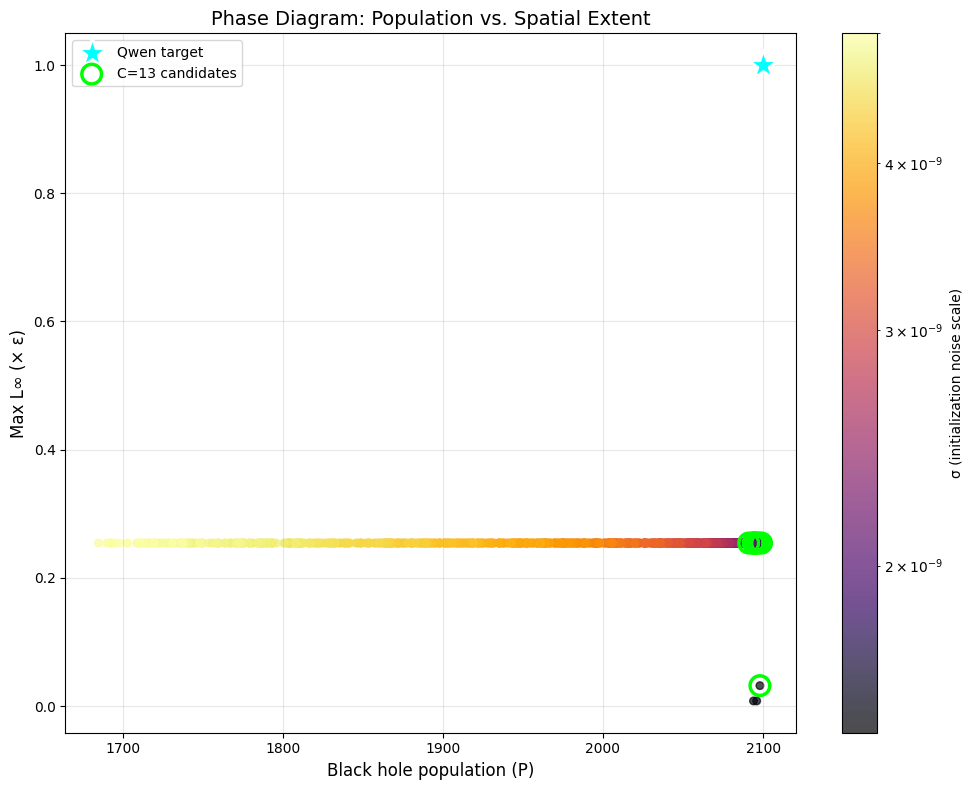

In [8]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

# Color by sigma
scatter = ax.scatter(
    df['black_hole_population'],
    df['max_l_inf_over_epsilon'],
    c=df['sigma'],
    s=30,
    alpha=0.7,
    cmap='inferno',
    norm=plt.matplotlib.colors.LogNorm()
)

# Mark Qwen target
ax.scatter(
    [TARGET_POPULATION],
    [TARGET_MAX_L_INF/EPSILON],
    marker='*',
    s=500,
    color='cyan',
    edgecolor='white',
    linewidth=2,
    label='Qwen target',
    zorder=10
)

# Mark C=13 candidates
if len(candidates) > 0:
    ax.scatter(
        candidates['black_hole_population'],
        candidates['max_l_inf_over_epsilon'],
        marker='o',
        s=200,
        facecolors='none',
        edgecolors='lime',
        linewidth=2.5,
        label=f'C={TARGET_BLACK_HOLES} candidates',
        zorder=9
    )

ax.set_xlabel('Black hole population (P)', fontsize=12)
ax.set_ylabel('Max L∞ (× ε)', fontsize=12)
ax.set_title('Phase Diagram: Population vs. Spatial Extent', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('σ (initialization noise scale)', fontsize=10)

plt.tight_layout()
plt.show()

## Summary

In [9]:
print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(f"Total samples: {len(df):,}")
print(f"Sigma range: [{df['sigma'].min():.2e}, {df['sigma'].max():.2e}]")
print(f"\nBlack hole statistics:")
print(f"  Samples with BH: {samples_with_bh:,} ({samples_with_bh/len(df)*100:.1f}%)")
print(f"  C = {TARGET_BLACK_HOLES} matches: {len(candidates)}")

if len(candidates) > 0:
    best = candidates_sorted.iloc[0]
    print(f"\nBest match to Qwen:")
    print(f"  σ = {best['sigma']:.2e} ({best['sigma_over_epsilon']:.4f}× ε)")
    print(f"  Population: {best['black_hole_population']:.0f} / {TARGET_POPULATION} (error: {best['pop_error']*100:.1f}%)")
    print(f"  Max L∞: {best['max_l_inf']:.2e} / {TARGET_MAX_L_INF:.2e} (error: {best['max_l_inf_error']*100:.1f}%)")
    print(f"  Combined error: {best['combined_error']:.3f}")
    
    # Interpretation
    if best['pop_error'] < 0.1 and best['max_l_inf_error'] < 0.2:
        print(f"\n✓ EXCELLENT MATCH: Both population and spatial extent within 20% of Qwen")
    elif best['combined_error'] < 0.5:
        print(f"\n✓ GOOD MATCH: Structure reasonably close to Qwen")
    else:
        print(f"\n⚠ PARTIAL MATCH: Black hole count correct but structure differs")
else:
    print(f"\n✗ NO EXACT MATCH: No samples produced exactly {TARGET_BLACK_HOLES} black holes")
    print(f"\nConsider sweeping a different sigma range.")

print(f"{'='*60}")


SUMMARY
Total samples: 1,000
Sigma range: [1.50e-09, 5.00e-09]

Black hole statistics:
  Samples with BH: 1,000 (100.0%)
  C = 13 matches: 10

Best match to Qwen:
  σ = 1.51e-09 (0.0000× ε)
  Population: 2099 / 2100 (error: 0.0%)
  Max L∞: 1.53e-05 / 6.00e-05 (error: 74.6%)
  Combined error: 0.746

⚠ PARTIAL MATCH: Black hole count correct but structure differs
